DATASET_DIR: /content/drive/MyDrive/KULIAH/SEMESTER 5/PCD/CBIR/dataset
Kelas di db: ['apple', 'banana', 'kiwi', 'orange']
Folder query: ['apple_test', 'banana_test', 'kiwi_test', 'orange_test']

Jumlah per kelas (db/):
  apple       :  15
  banana      :  14
  kiwi        :  14
  orange      :  12
Total gambar db: 55

Jumlah per folder (query/):
  apple_test  :   3
  banana_test :   3
  kiwi_test   :   3
  orange_test :   3

Base label db   : ['apple', 'banana', 'kiwi', 'orange']
Base label query: ['apple', 'banana', 'kiwi', 'orange']
Cek dataset: OK


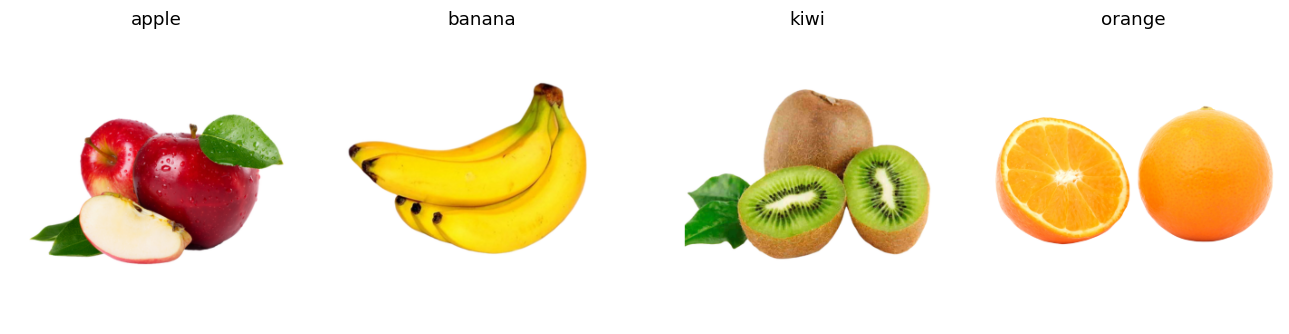

In [ ]:
# LANGKAH 0A - IMPORT & SETUP
import os
import glob
import math
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import StandardScaler

plt.rcParams["figure.dpi"] = 110

DATASET_DIR = "/content/drive/MyDrive/KULIAH/SEMESTER 5/PCD/CBIR/dataset"
db_root    = os.path.join(DATASET_DIR, "db")
query_root = os.path.join(DATASET_DIR, "query")

assert os.path.isdir(db_root),    f"Tidak ada folder: {db_root}"
assert os.path.isdir(query_root), f"Tidak ada folder: {query_root}"

EXTS = ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff")

def imread_rgb(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None: raise FileNotFoundError(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def base_label(name: str):
    return name.split('_')[0].lower()


# LANGKAH 0B - RINGKASAN DATASET
classes_db = sorted([d for d in os.listdir(db_root) if os.path.isdir(os.path.join(db_root,d))])
classes_q  = sorted([d for d in os.listdir(query_root) if os.path.isdir(os.path.join(query_root,d))])

def count_images(root):
    out = {}
    for cls in sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root,d))]):
        files = []
        for ext in EXTS: files += glob.glob(os.path.join(root, cls, ext))
        out[cls] = len(files)
    return out

db_counts = count_images(db_root)
q_counts  = count_images(query_root)

print("DATASET_DIR:", DATASET_DIR)
print("Kelas di db:", classes_db)
print("Folder query:", classes_q)
print("\nJumlah per kelas (db/):")
total_db = 0
for k,v in db_counts.items():
    print(f"  {k:12s}: {v:3d}")
    total_db += v
print("Total gambar db:", total_db)

print("\nJumlah per folder (query/):")
for k,v in q_counts.items():
    print(f"  {k:12s}: {v:3d}")

db_base = sorted({base_label(c) for c in classes_db})
q_base  = sorted({base_label(c) for c in classes_q})
print("\nBase label db   :", db_base)
print("Base label query:", q_base)
assert set(db_base) == set(q_base), "Nama kelas db dan query tidak konsisten."
print("Cek dataset: OK")


# LANGKAH 0C - PREVIEW 1 GAMBAR PER KELAS (db/)
n = len(classes_db)
if n > 0:
    fig, axs = plt.subplots(1, n, figsize=(3.0*n, 3.0))
    if n == 1: axs = [axs]
    for ax, cls in zip(axs, classes_db):
        files = []
        for ext in EXTS: files += glob.glob(os.path.join(db_root, cls, ext))
        if files:
            ax.imshow(imread_rgb(sorted(files)[0]))
            ax.set_title(cls)
        ax.axis('off')
    plt.tight_layout(); plt.show()
else:
    print("db/ kosong.")

LANGKAH 2

In [ ]:
# LANGKAH 2 - Ekstraksi Fitur (fg_mask, warna, tekstur, bentuk)
def to_gray(img_rgb):
    return cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

def fg_mask(img_rgb, min_sat=25, min_val=30):
    """Mask foreground berbasis HSV (buang piksel sangat rendah saturasi/gelap)."""
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    S, V = hsv[...,1], hsv[...,2]
    m = ((S > min_sat) & (V > min_val)).astype(np.uint8) * 255
    m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, np.ones((7,7), np.uint8))
    m = cv2.morphologyEx(m, cv2.MORPH_OPEN,  np.ones((5,5), np.uint8))
    return m

def color_features(img_rgb, h_bins=16, s_bins=8, v_bins=8):
    """HSV histogram 16-8-8 + mean,std,skew,kurt per kanal (dengan mask)."""
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    H, S, V = cv2.split(hsv)
    mask = fg_mask(img_rgb)

    h = cv2.calcHist([H],[0],mask,[h_bins],[0,180]).flatten()
    s = cv2.calcHist([S],[0],mask,[s_bins],[0,256]).flatten()
    v = cv2.calcHist([V],[0],mask,[v_bins],[0,256]).flatten()
    h /= (h.sum()+1e-8); s /= (s.sum()+1e-8); v /= (v.sum()+1e-8)

    def stats(x):
        x = x.astype(np.float64)
        mu = x.mean(); sd = x.std()+1e-8
        skew = ((x-mu)**3).mean()/(sd**3)
        kurt = ((x-mu)**4).mean()/(sd**4)
        return [mu, sd, skew, kurt]

    feat = np.hstack([h, s, v, stats(h), stats(s), stats(v)])
    return feat.astype(np.float64)  # 44 dim

def glcm_features(img_rgb, levels=16, d=1):
    """GLCM 4 arah (0°,45°,90°,135°) → mean [contrast, correlation, energy, homogeneity]."""
    gray = to_gray(img_rgb)
    gray_q = np.uint8(gray / (256/levels))
    P = graycomatrix(gray_q, [d],
                     angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                     levels=levels, symmetric=True, normed=True)
    feats = [graycoprops(P, p).mean() for p in ("contrast","correlation","energy","homogeneity")]
    return np.array(feats, dtype=np.float64)  # 4 dim

def shape_features(img_rgb):
    """Fitur bentuk dari kontur komponen terbesar pada fg_mask: area, perimeter, aspect, extent, solidity, circularity."""
    m = fg_mask(img_rgb)

    num, labels, stats, _ = cv2.connectedComponentsWithStats(m, connectivity=8)
    if num <= 1:
        return np.zeros(6, dtype=np.float64)
    idx = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    comp = (labels == idx).astype(np.uint8) * 255

    cs, _ = cv2.findContours(comp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cs:
        return np.zeros(6, dtype=np.float64)
    cnt = max(cs, key=cv2.contourArea)

    area = float(cv2.contourArea(cnt))
    peri  = float(cv2.arcLength(cnt, True))

    rect = cv2.minAreaRect(cnt)
    rw, rh = rect[1]
    if rw > 0 and rh > 0:
        aspect = max(rw, rh) / (min(rw, rh) + 1e-8)
    else:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect = w / (h + 1e-8)

    x, y, w, h = cv2.boundingRect(cnt)
    extent = area / (w * h + 1e-8)

    hull = cv2.convexHull(cnt)
    hull_area = float(cv2.contourArea(hull))
    solidity = area / (hull_area + 1e-8)

    circularity = (4.0 * math.pi * area) / (peri**2 + 1e-8) if peri > 0 else 0.0
    return np.array([area, peri, aspect, extent, solidity, circularity], dtype=np.float64)

print("Fungsi fitur siap")


Fungsi fitur siap


In [ ]:
# CEK DIMENSI FITUR
def imread_rgb(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None: raise FileNotFoundError(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 1 gambar dari db
exts = ("*.jpg","*.jpeg","*.png")
cls0 = sorted([d for d in os.listdir(db_root) if os.path.isdir(os.path.join(db_root,d))])[0]
cands = []
for ext in exts:
    cands += glob.glob(os.path.join(db_root, cls0, ext))
img_path = sorted(cands)[0]

img = imread_rgb(img_path)
fc = color_features(img)
ft = glcm_features(img)
fs = shape_features(img)

print("Dimensi fitur:")
print(f"  Warna (HSV 16-8-8 + stats): {fc.shape[0]}  [expected 44]")
print(f"  Tekstur (GLCM rata-rata)  : {ft.shape[0]}  [expected 4]")
print(f"  Bentuk (6 metrik)         : {fs.shape[0]}  [expected 6]")
print(f"  Total                     : {fc.size + ft.size + fs.size}")

Dimensi fitur:
  Warna (HSV 16-8-8 + stats): 44  [expected 44]
  Tekstur (GLCM rata-rata)  : 4  [expected 4]
  Bentuk (6 metrik)         : 6  [expected 6]
  Total                     : 54


apple - 1.png


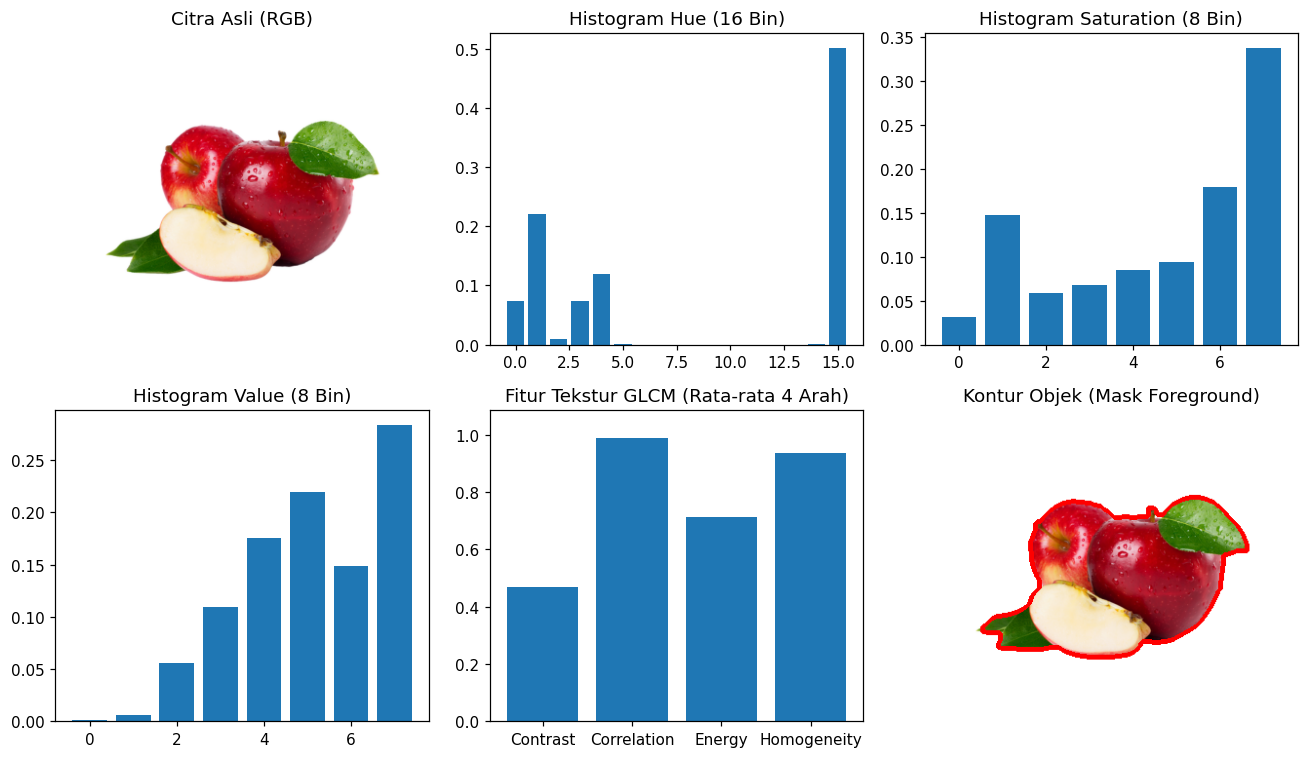

banana - 1.png


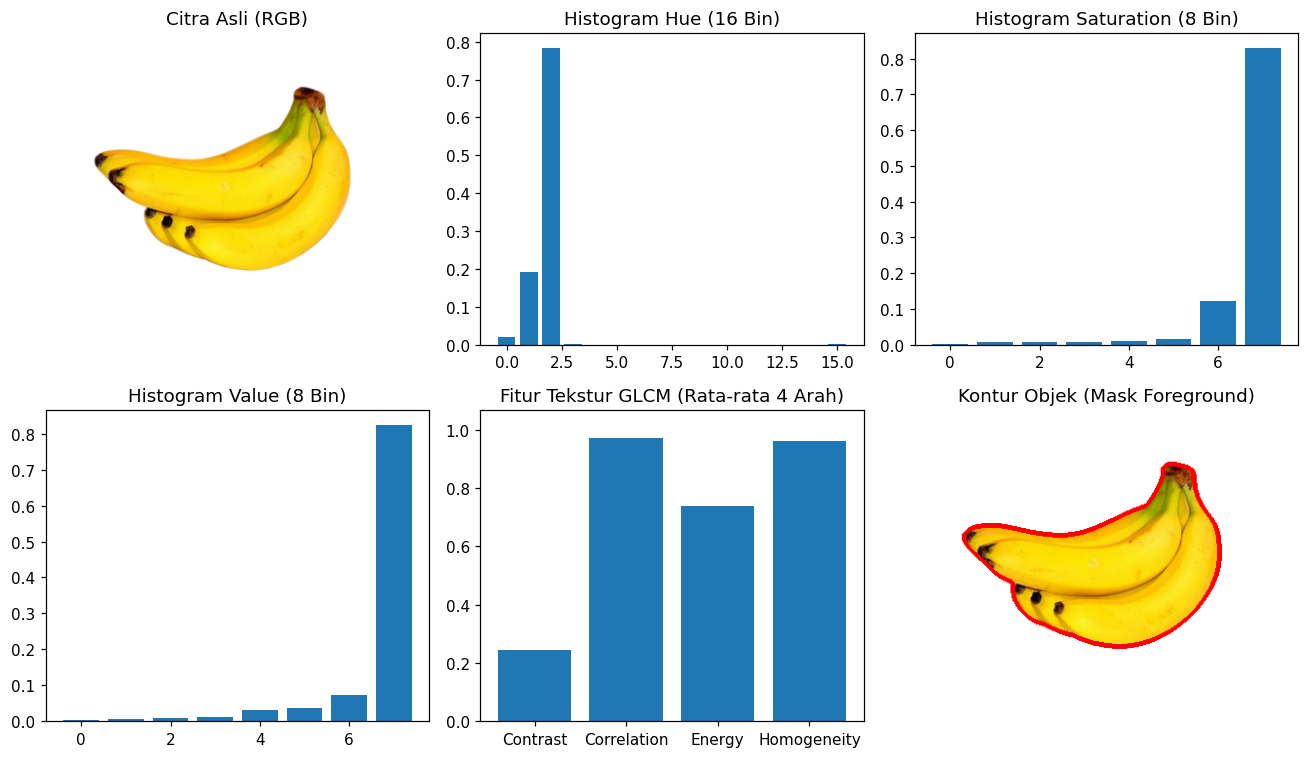

kiwi - 1.png


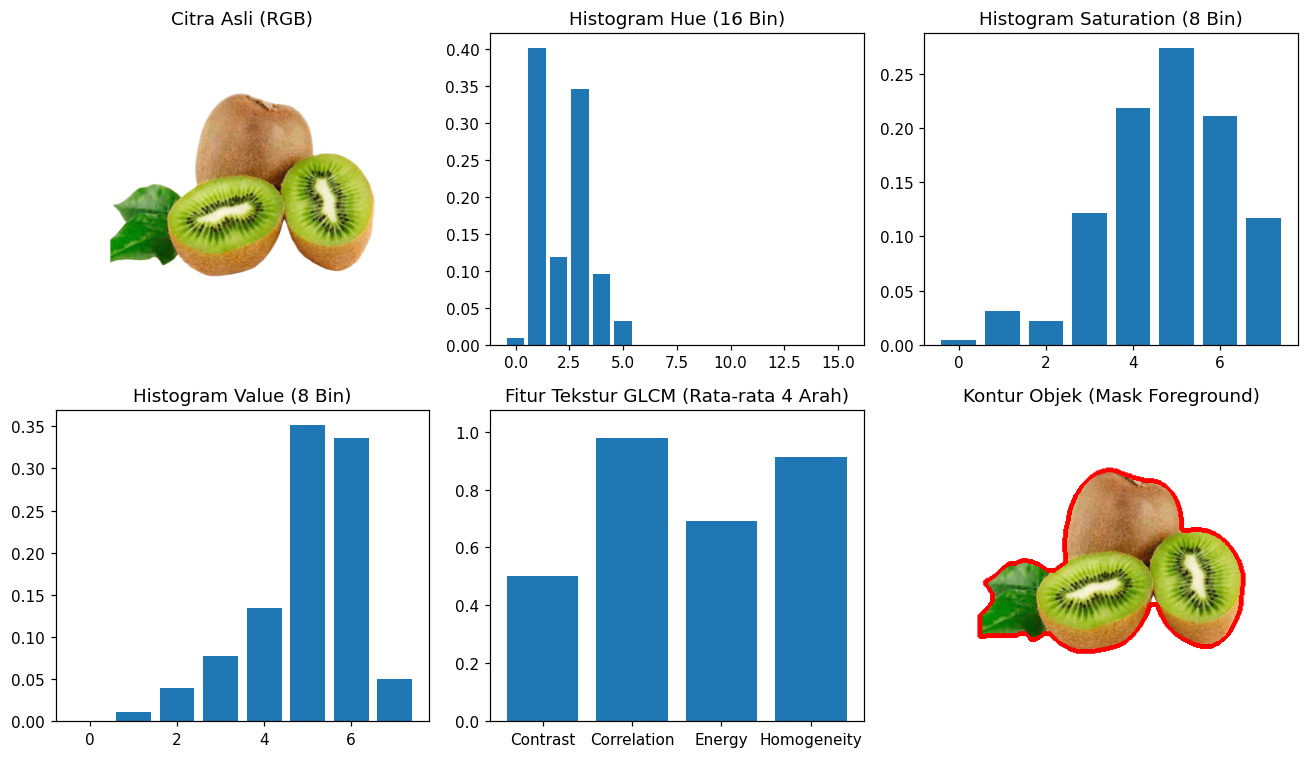

orange - 1.png


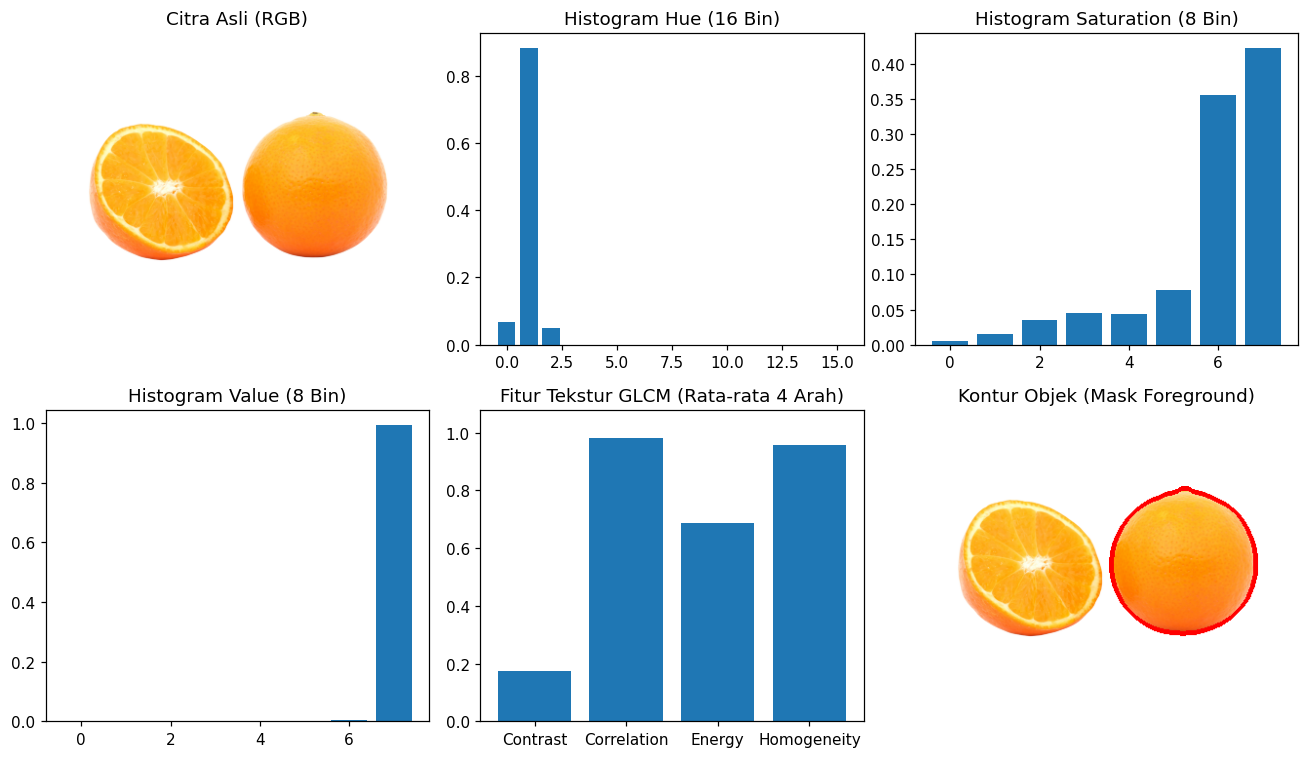

In [ ]:
# VISUALISASI: histogram HSV, nilai GLCM, kontur foreground
def visualize_feature_example(img_path):
    img = imread_rgb(img_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H,S,V = cv2.split(hsv)
    mask = fg_mask(img)

    h_bins, s_bins, v_bins = 16, 8, 8
    h_hist = cv2.calcHist([H],[0],mask,[h_bins],[0,180]).flatten()
    s_hist = cv2.calcHist([S],[0],mask,[s_bins],[0,256]).flatten()
    v_hist = cv2.calcHist([V],[0],mask,[v_bins],[0,256]).flatten()
    h_hist /= (h_hist.sum()+1e-8)
    s_hist /= (s_hist.sum()+1e-8)
    v_hist /= (v_hist.sum()+1e-8)

    ft = glcm_features(img)  # [contrast, correlation, energy, homogeneity]

    cs,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cs, key=cv2.contourArea) if cs else None
    overlay = img.copy()
    if cnt is not None:
        cv2.drawContours(overlay, [cnt], -1, (255,0,0), 3)

    fig = plt.figure(figsize=(12,7)); ax1 = plt.subplot2grid((2,3),(0,0)); ax1.imshow(img); ax1.axis('off'); ax1.set_title("Citra Asli (RGB)");
    ax2 = plt.subplot2grid((2,3),(0,1)); ax2.bar(np.arange(h_bins), h_hist); ax2.set_title("Histogram Hue (16 Bin)");
    ax3 = plt.subplot2grid((2,3),(0,2)); ax3.bar(np.arange(s_bins), s_hist); ax3.set_title("Histogram Saturation (8 Bin)");
    ax4 = plt.subplot2grid((2,3),(1,0)); ax4.bar(np.arange(v_bins), v_hist); ax4.set_title("Histogram Value (8 Bin)");
    props = ["Contrast","Correlation","Energy","Homogeneity"]; ax5 = plt.subplot2grid((2,3),(1,1)); ax5.bar(props, ft); ax5.set_title("Fitur Tekstur GLCM (Rata-rata 4 Arah)"); ax5.set_ylim(0, max(1.0, ft.max()*1.1));
    ax6 = plt.subplot2grid((2,3),(1,2)); ax6.imshow(overlay); ax6.axis('off'); ax6.set_title("Kontur Objek (Mask Foreground)");
    plt.tight_layout(); plt.show()

def pick_one_per_class(root):
    exts = ("*.jpg","*.jpeg","*.png")
    out = []
    for cls in sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root,d))]):
        files = []
        for ext in exts: files += glob.glob(os.path.join(root, cls, ext))
        if files: out.append(sorted(files)[0])
    return out

for p in pick_one_per_class(db_root):
    print(os.path.basename(os.path.dirname(p)), "-", os.path.basename(p))
    visualize_feature_example(p)


In [ ]:
def simpan_fitur_raw(db_root, out_csv="/mnt/data/fitur_raw_laporan.csv"):
    data = []
    exts = ("*.jpg", "*.jpeg", "*.png")

    for cls in sorted([d for d in os.listdir(db_root) if os.path.isdir(os.path.join(db_root, d))]):
        files = []
        for ext in exts:
            files += glob.glob(os.path.join(db_root, cls, ext))
        for path in sorted(files):
            img = imread_rgb(path)
            f_warna  = color_features(img)
            f_tekstur = glcm_features(img)
            f_bentuk  = shape_features(img)

            row = {"path": path, "label": cls}
            for i, v in enumerate(f_warna):  row[f"warna_{i}"]  = float(v)
            for i, v in enumerate(f_tekstur): row[f"tekstur_{i}"] = float(v)
            for i, v in enumerate(f_bentuk):  row[f"bentuk_{i}"]  = float(v)
            data.append(row)

    df = pd.DataFrame(data)
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    df.to_csv(out_csv, index=False)
    print(f"File CSV fitur mentah tersimpan di: {out_csv}")
    print("Jumlah data:", df.shape)

simpan_fitur_raw(db_root)


File CSV fitur mentah tersimpan di: /mnt/data/fitur_raw_laporan.csv
Jumlah data: (55, 56)


In [ ]:
import pandas as pd

df = pd.read_csv("/mnt/data/fitur_raw_laporan.csv")
df_clean = df.drop(columns=['path'])

out_path = "/mnt/data/features.csv"
df_clean.to_csv(out_path, index=False)

print("Ukuran:", df_clean.shape)
print("File tersimpan di:", out_path)
display(df_clean.head())


Ukuran: (55, 55)
File tersimpan di: /mnt/data/features.csv


,label,warna_0,warna_1,warna_2,warna_3,warna_4,warna_5,warna_6,warna_7,warna_8,...,tekstur_0,tekstur_1,tekstur_2,tekstur_3,bentuk_0,bentuk_1,bentuk_2,bentuk_3,bentuk_4,bentuk_5
0,apple,0.074195,0.221086,0.009922,0.074025,0.119067,0.000205,0.000000,0.0,0.000000,...,0.469609,0.987190,0.713204,0.936733,28968.5,812.683328,1.696918,0.645466,0.870461,0.551180
1,apple,0.170121,0.242483,0.051270,0.007517,0.041198,0.004233,0.000000,0.0,0.000073,...,0.451464,0.977741,0.718069,0.924007,28285.5,1170.874232,1.212141,0.591450,0.815967,0.259271
2,apple,0.094564,0.002179,0.000754,0.001956,0.017181,0.028886,0.000279,0.0,0.000000,...,0.351862,0.993591,0.651484,0.941938,35766.5,927.310744,1.192053,0.695738,0.900897,0.522680
3,apple,0.019261,0.007985,0.008300,0.000919,0.000000,0.000024,0.000000,0.0,0.000024,...,0.283106,0.992487,0.583857,0.916736,41485.5,786.139171,1.143694,0.762671,0.986224,0.843543
4,apple,0.393509,0.001063,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.231093,0.994726,0.786429,0.974143,21299.0,564.274166,1.118421,0.814089,0.978882,0.840599


#LANGKAH 3

In [ ]:
# LANGKAH 3.0 - Membuat indeks fitur dari folder db/ (ekstraksi dan normalisasi)
EXTS = ("*.jpg", "*.jpeg", "*.png")

def imread_rgb(path):
    import cv2
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def buat_index_dari_db(db_root):
    paths, labels = [], []
    fitur_warna, fitur_tekstur, fitur_bentuk = [], [], []

    for cls in sorted([d for d in os.listdir(db_root) if os.path.isdir(os.path.join(db_root, d))]):
        files = []
        for ext in EXTS:
            files += glob.glob(os.path.join(db_root, cls, ext))
        for p in sorted(files):
            img = imread_rgb(p)
            fitur_warna.append(color_features(img))
            fitur_tekstur.append(glcm_features(img))
            fitur_bentuk.append(shape_features(img))
            paths.append(p)
            labels.append(cls)

    # Konversi ke array
    Xc = np.vstack(fitur_warna).astype(np.float64)
    Xt = np.vstack(fitur_tekstur).astype(np.float64)
    Xs = np.vstack(fitur_bentuk).astype(np.float64)

    # Normalisasi tiap blok fitur
    sc_c = StandardScaler().fit(Xc)
    sc_t = StandardScaler().fit(Xt)
    sc_s = StandardScaler().fit(Xs)
    Xc = sc_c.transform(Xc)
    Xt = sc_t.transform(Xt)
    Xs = sc_s.transform(Xs)

    df_index = pd.DataFrame({'path': paths, 'label': labels})
    print(f"Jumlah citra terindeks: {len(df_index)} dari {len(sorted(set(labels)))} kelas.")
    print("Ukuran fitur - Warna:", Xc.shape, "| Tekstur:", Xt.shape, "| Bentuk:", Xs.shape)
    return (Xc, Xt, Xs), (sc_c, sc_t, sc_s), df_index

feats_pack, scalers, df_index = buat_index_dari_db(db_root)


Jumlah citra terindeks: 55 dari 4 kelas.
Ukuran fitur - Warna: (55, 44) | Tekstur: (55, 4) | Bentuk: (55, 6)


In [ ]:
# LANGKAH 3.1 - Retrieval dengan jarak Euclidean
def base_label(name: str) -> str:
    return name.split('_')[0].lower()

def retrieve(query_path, feats_pack, df_index, scalers,
             topk=5, weights=(0.8, 0.2, 1.0), metric='euclidean'):
    if metric != 'euclidean':
        raise ValueError("error (bukan euclidean).")

    Xc, Xt, Xs = feats_pack
    sc_c, sc_t, sc_s = scalers

    qimg = imread_rgb(query_path)
    qc = sc_c.transform(color_features(qimg).reshape(1, -1))[0]
    qt = sc_t.transform(glcm_features(qimg).reshape(1, -1))[0]
    qs = sc_s.transform(shape_features(qimg).reshape(1, -1))[0]

    DB = np.hstack([weights[0]*Xc, weights[1]*Xt, weights[2]*Xs])
    q  = np.hstack([weights[0]*qc, weights[1]*qt, weights[2]*qs])

    dists = np.linalg.norm(DB - q, axis=1)

    idx = np.argsort(dists)[:topk]
    hasil = [(float(dists[i]), df_index['path'].iloc[i], df_index['label'].iloc[i]) for i in idx]
    return qimg, hasil


In [ ]:
# LANGKAH 3.2 - Menampilkan hasil Top-k citra mirip
def show_topk(qpath, feats_pack, df_index, scalers,
              weights=(0.8, 0.2, 1.0), metric='euclidean', topk=5):
    qimg, hasil = retrieve(qpath, feats_pack, df_index, scalers,
                           topk=topk, weights=weights, metric=metric)
    q_cls = os.path.basename(os.path.dirname(qpath))

    plt.figure(figsize=(3.2, 3.2))
    plt.imshow(qimg)
    plt.axis('off')
    plt.title(f"Query ({q_cls})", weight='bold')
    plt.show()

    fig, axes = plt.subplots(1, topk, figsize=(14, 3))

    for i, (d, p, lab) in enumerate(hasil, 1):
        img_res = imread_rgb(p)
        ax = axes[i-1]
        ax.imshow(img_res)
        ax.axis('off')
        warna = 'green' if base_label(lab) == base_label(q_cls) else 'red'
        rect = patches.Rectangle((0, 0), img_res.shape[1], img_res.shape[0],
                                 linewidth=4, edgecolor=warna, facecolor='none')
        ax.add_patch(rect)
        ax.set_title(f"{lab}\nD={d:.3f}", fontsize=10)

    plt.tight_layout()
    plt.show()

    print(f"[{base_label(q_cls)}] Top-{topk} hasil pencarian:")
    for d, p, lab in hasil:
        print(f"{d:8.4f} | {lab:<8} | {os.path.basename(p)}")

In [ ]:
def show_topk(qpath, feats_pack, df_index, scalers,
              weights=(1.0, 0.15, 0.90), metric='euclidean', topk=5,
              show_mode="both", savepath=None):
    # Ambil citra query dan hasil retrieval
    qimg, hasil = retrieve(qpath, feats_pack, df_index, scalers,
                           topk=topk, weights=weights, metric=metric)
    q_cls = os.path.basename(os.path.dirname(qpath))
    q_file = os.path.basename(qpath)

    # Hitung skor kemiripan absolut dan relatif
    dists = np.array([d for d, _, _ in hasil], dtype=float)
    sims_abs = 100.0 / (1.0 + dists)
    dmin, dmax = float(dists.min()), float(dists.max())
    sims_rel = (np.ones_like(dists) * 100.0) if (dmax - dmin < 1e-12) \
               else 100.0 * (1.0 - (dists - dmin) / (dmax - dmin))

    cols = topk
    fig = plt.figure(figsize=(3.0 * cols, 4.4))
    gs = fig.add_gridspec(2, cols, height_ratios=[1.25, 1.0])

    fig.text(0.01, 0.965,
             f"weights=(W,T,B)=({weights[0]}, {weights[1]}, {weights[2]})",
             fontsize=9, ha="left", va="top")

    # Tampilkan citra query
    axq = fig.add_subplot(gs[0, :])
    axq.imshow(qimg)
    axq.axis('off')
    axq.set_title(f"Query: {q_cls} | File: {q_file}",
                  fontsize=12, fontweight="bold", pad=8)

    # Tampilkan hasil top-k
    for i, ((d, p, lab), sa, sr) in enumerate(zip(hasil, sims_abs, sims_rel)):
        ax = fig.add_subplot(gs[1, i])
        img_res = imread_rgb(p)
        ax.imshow(img_res)
        ax.axis('off')

        ok = (base_label(lab) == base_label(q_cls))
        edge = 'tab:green' if ok else 'tab:red'
        rect = patches.Rectangle((0, 0), img_res.shape[1], img_res.shape[0],
                                 linewidth=3, edgecolor=edge, facecolor='none')
        ax.add_patch(rect)

        fname = os.path.basename(p)
        if show_mode == "abs":
            cap = f"{lab} | {fname}\nD={d:.3f} | Abs={sa:.1f}%"
        elif show_mode == "rel":
            cap = f"{lab} | {fname}\nD={d:.3f} | Rel={sr:.1f}%"
        else:
            cap = f"{lab} | {fname}\nD={d:.3f} | Abs={sa:.1f}% | Rel={sr:.1f}%"
        ax.set_title(cap, fontsize=9, pad=6)

    plt.tight_layout(rect=[0, 0, 1, 0.94])

    # Tampilkan gambar
    plt.show()

    # Tampilkan tabel
    print(f"\nQuery file: {q_file}\n")
    df_out = pd.DataFrame({
        "Rank": np.arange(1, topk + 1),
        "Label": [lab for _, _, lab in hasil],
        "File": [os.path.basename(p) for _, p, _ in hasil],
        "Distance": [float(d) for d, _, _ in hasil],
        "Abs%": [float(sa) for sa in sims_abs],
        "Rel%": [float(sr) for sr in sims_rel],
    })
    display(df_out)
    print("-" * 60)

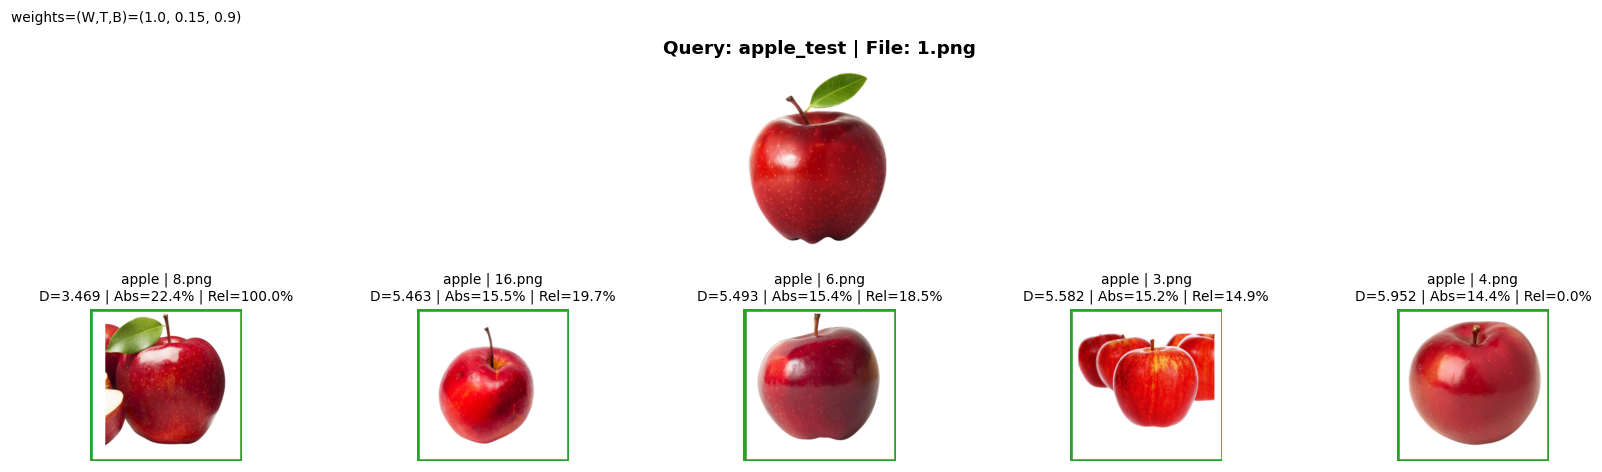


Query file: 1.png



,Rank,Label,File,Distance,Abs%,Rel%
0,1,apple,8.png,3.468660,22.378071,100.000000
1,2,apple,16.png,5.462638,15.473559,19.708204
2,3,apple,6.png,5.493310,15.400465,18.473100
3,4,apple,3.png,5.582061,15.192809,14.899350
4,5,apple,4.png,5.952074,14.384197,0.000000


------------------------------------------------------------


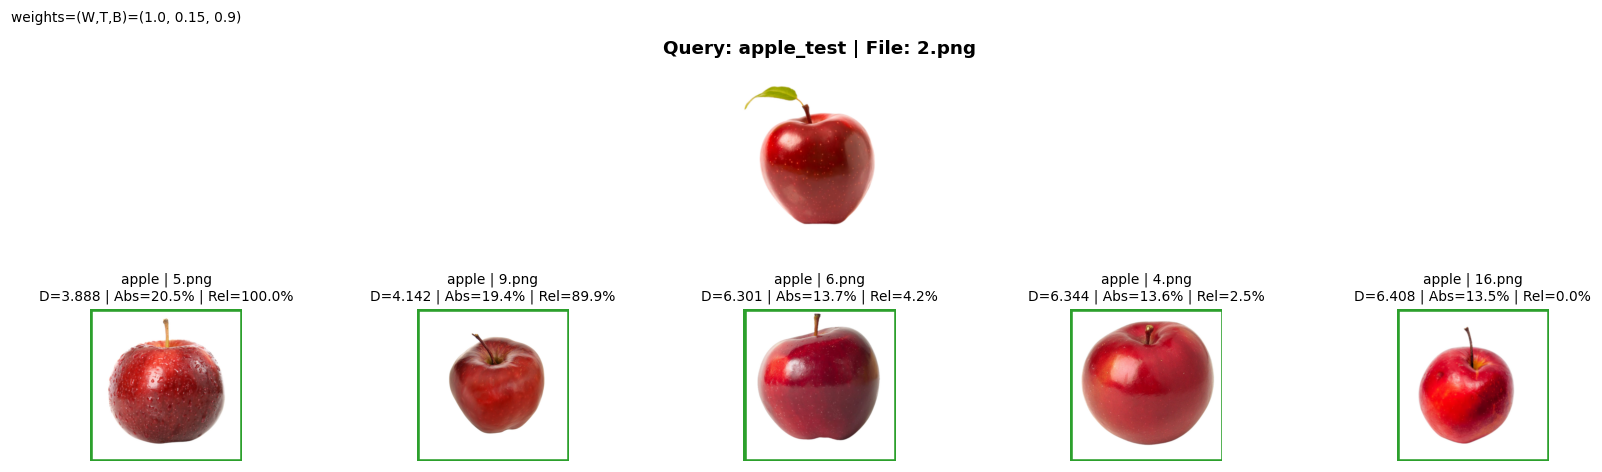


Query file: 2.png



,Rank,Label,File,Distance,Abs%,Rel%
0,1,apple,5.png,3.887751,20.459309,100.000000
1,2,apple,9.png,4.142329,19.446442,89.897374
2,3,apple,6.png,6.300721,13.697276,4.244231
3,4,apple,4.png,6.344415,13.615788,2.510306
4,5,apple,16.png,6.407673,13.499516,0.000000


------------------------------------------------------------


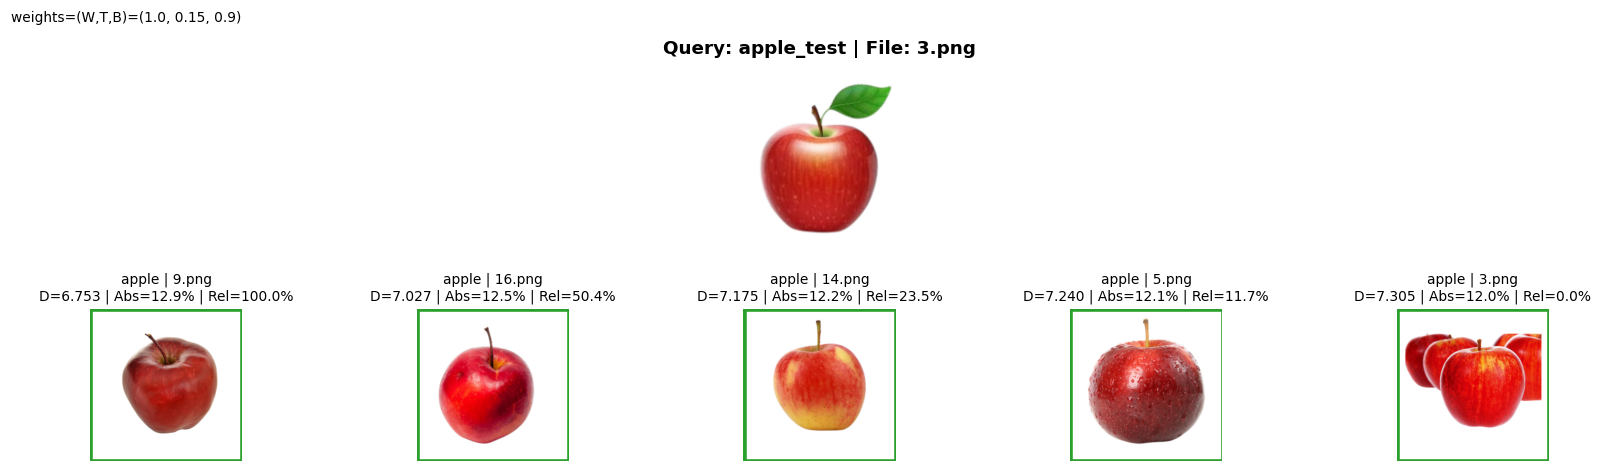


Query file: 3.png



,Rank,Label,File,Distance,Abs%,Rel%
0,1,apple,9.png,6.753222,12.897863,100.000000
1,2,apple,16.png,7.026710,12.458404,50.411914
2,3,apple,14.png,7.175304,12.231961,23.469369
3,4,apple,5.png,7.240054,12.135843,11.729120
4,5,apple,3.png,7.304742,12.041313,0.000000


------------------------------------------------------------


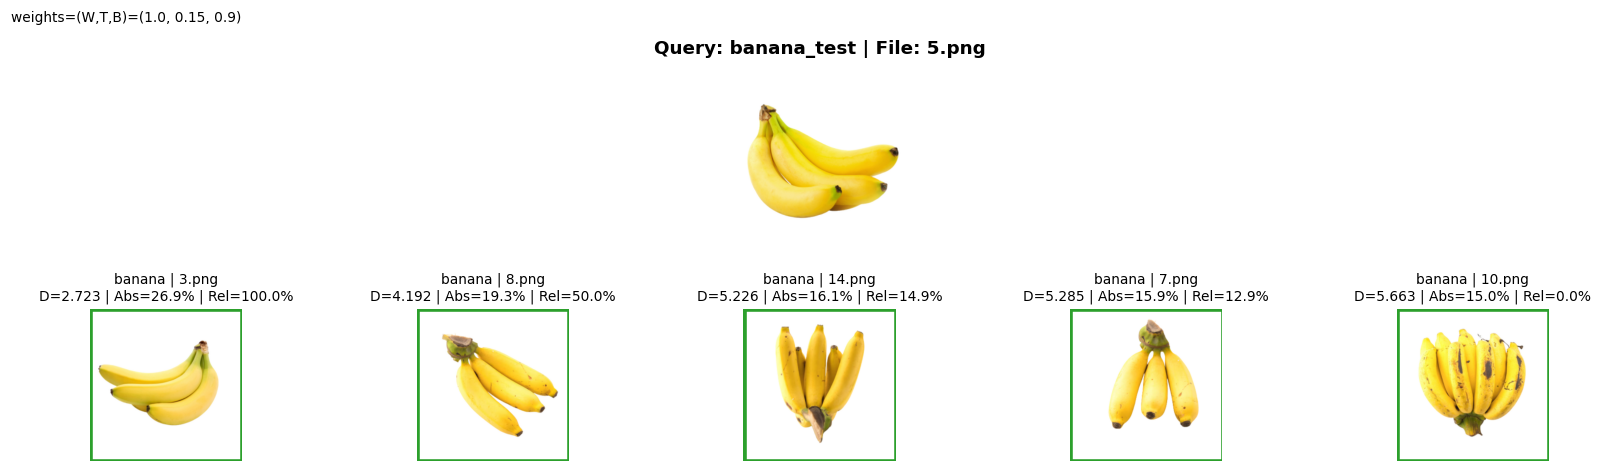


Query file: 5.png



,Rank,Label,File,Distance,Abs%,Rel%
0,1,banana,3.png,2.722879,26.860931,100.000000
1,2,banana,8.png,4.192462,19.258687,50.016973
2,3,banana,14.png,5.226046,16.061557,14.862995
3,4,banana,7.png,5.284701,15.911655,12.868044
4,5,banana,10.png,5.663043,15.008158,0.000000


------------------------------------------------------------


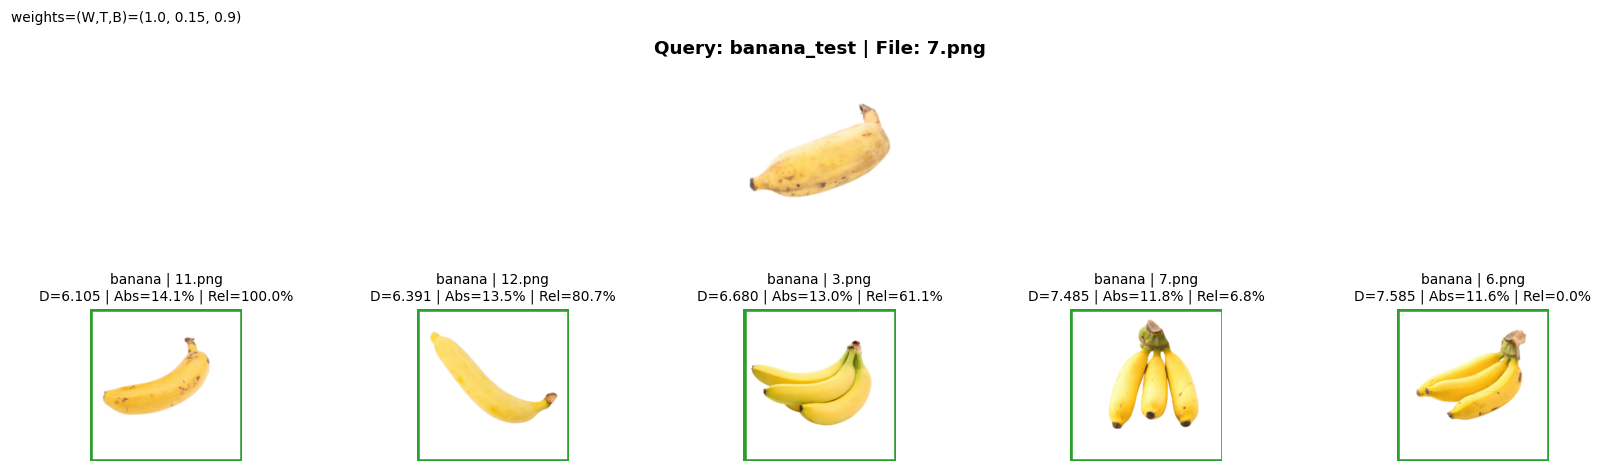


Query file: 7.png



,Rank,Label,File,Distance,Abs%,Rel%
0,1,banana,11.png,6.105035,14.074526,100.000000
1,2,banana,12.png,6.390811,13.530315,80.693652
2,3,banana,3.png,6.680333,13.020269,61.134233
3,4,banana,7.png,7.484616,11.786037,6.798703
4,5,banana,6.png,7.585252,11.647882,0.000000


------------------------------------------------------------


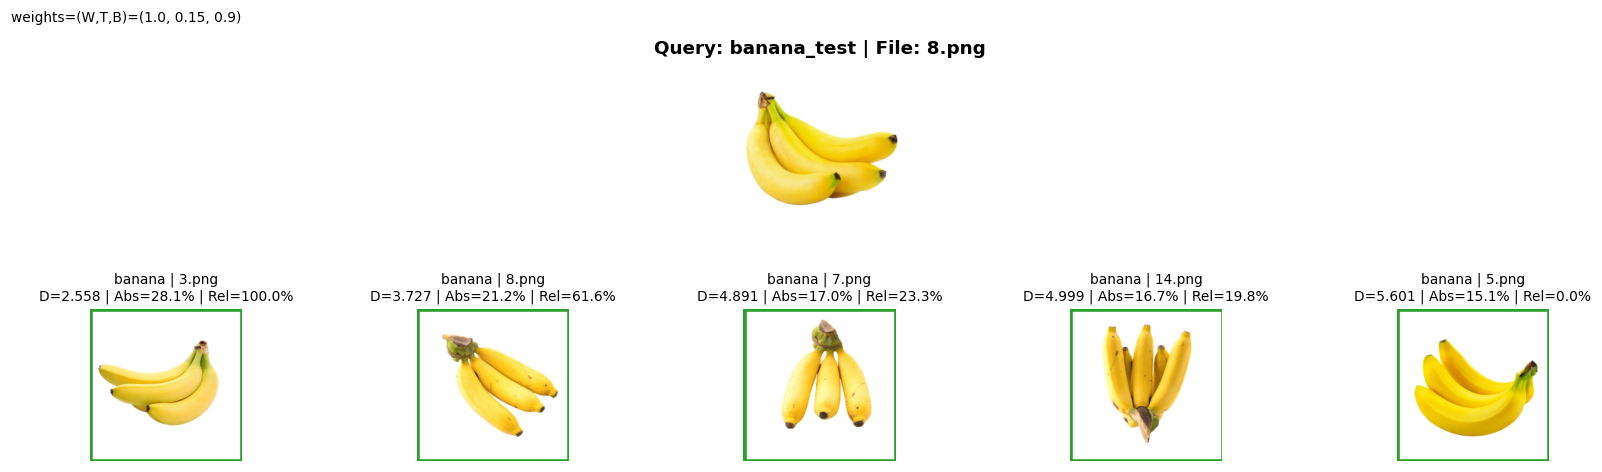


Query file: 8.png



,Rank,Label,File,Distance,Abs%,Rel%
0,1,banana,3.png,2.558272,28.103530,100.000000
1,2,banana,8.png,3.727499,21.152832,61.573977
2,3,banana,7.png,4.890721,16.975850,23.345332
3,4,banana,14.png,4.998905,16.669708,19.789919
4,5,banana,5.png,5.601073,15.149052,0.000000


------------------------------------------------------------


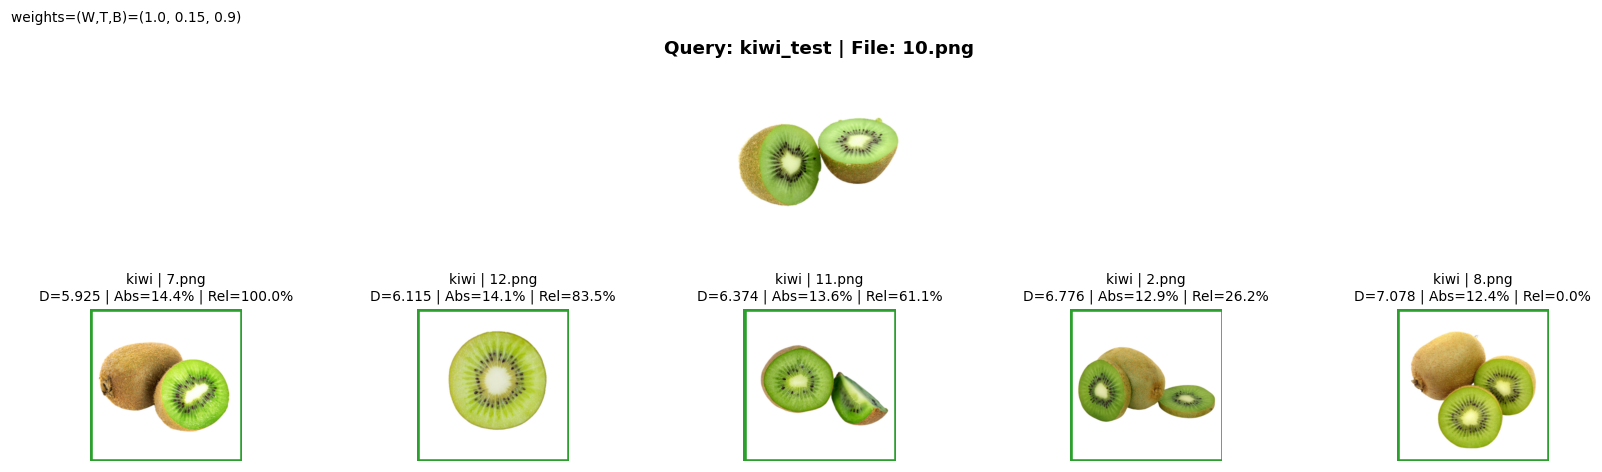


Query file: 10.png



,Rank,Label,File,Distance,Abs%,Rel%
0,1,kiwi,7.png,5.924913,14.440615,100.000000
1,2,kiwi,12.png,6.115324,14.054175,83.488210
2,3,kiwi,11.png,6.373686,13.561739,61.083889
3,4,kiwi,2.png,6.776175,12.859792,26.181347
4,5,kiwi,8.png,7.078094,12.379158,0.000000


------------------------------------------------------------


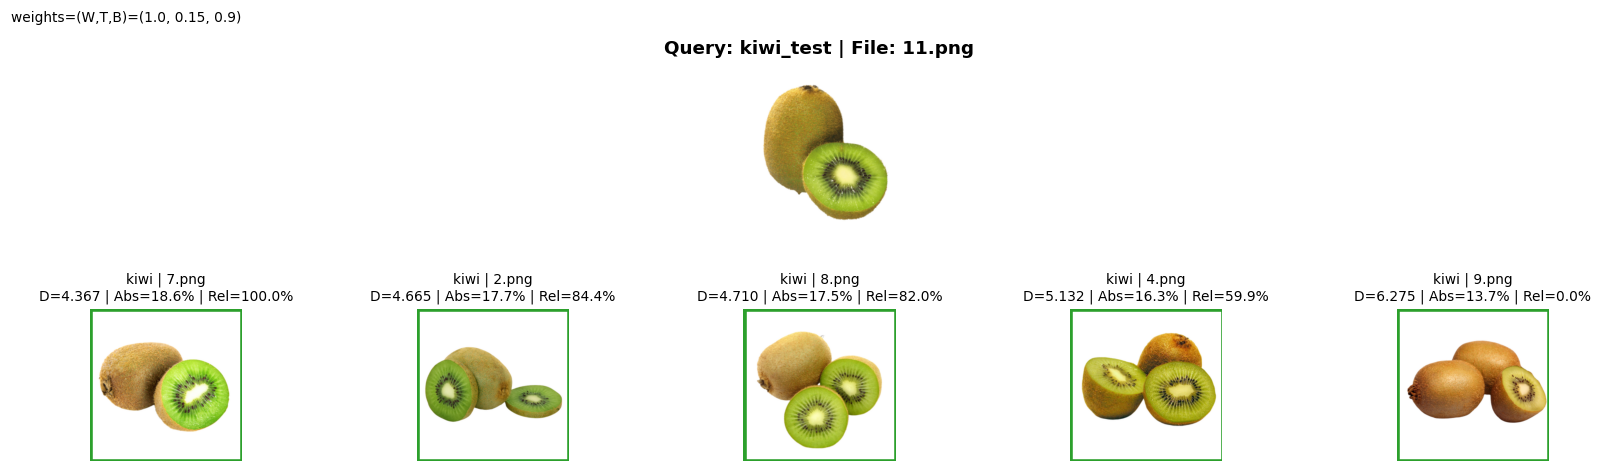


Query file: 11.png



,Rank,Label,File,Distance,Abs%,Rel%
0,1,kiwi,7.png,4.366696,18.633439,100.000000
1,2,kiwi,2.png,4.665348,17.651166,84.350526
2,3,kiwi,8.png,4.709765,17.513854,82.023046
3,4,kiwi,4.png,5.132026,16.307823,59.896434
4,5,kiwi,9.png,6.275081,13.745552,0.000000


------------------------------------------------------------


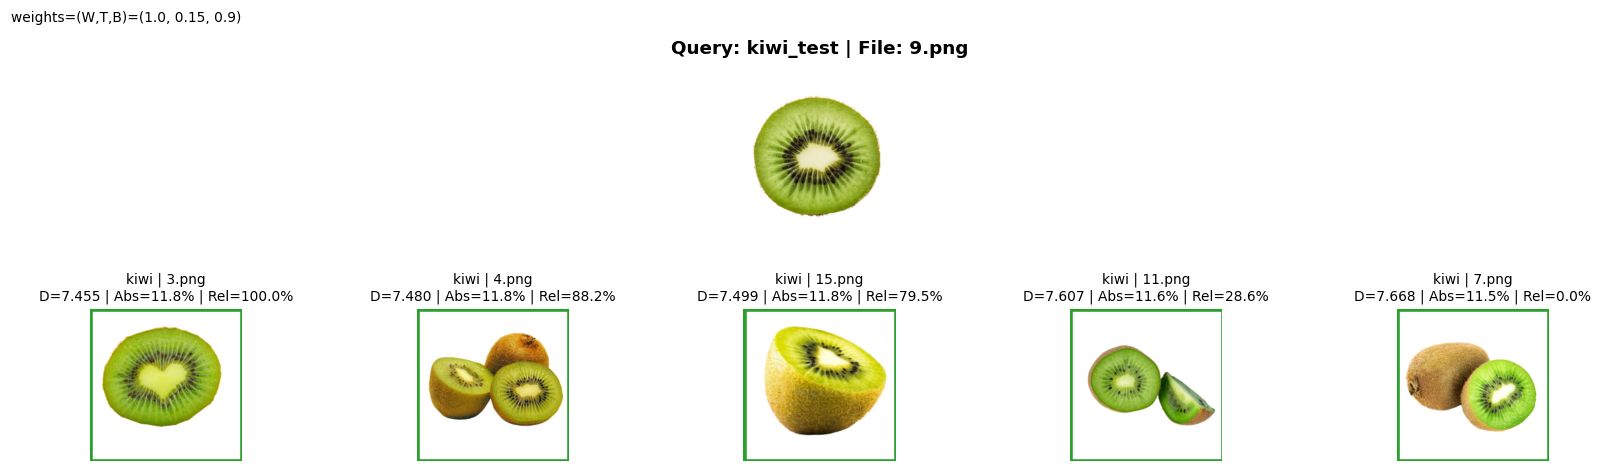


Query file: 9.png



,Rank,Label,File,Distance,Abs%,Rel%
0,1,kiwi,3.png,7.454812,11.827585,100.000000
1,2,kiwi,4.png,7.479970,11.792494,88.216874
2,3,kiwi,15.png,7.498592,11.766656,79.495682
3,4,kiwi,11.png,7.607207,11.618171,28.625816
4,5,kiwi,7.png,7.668327,11.536251,0.000000


------------------------------------------------------------


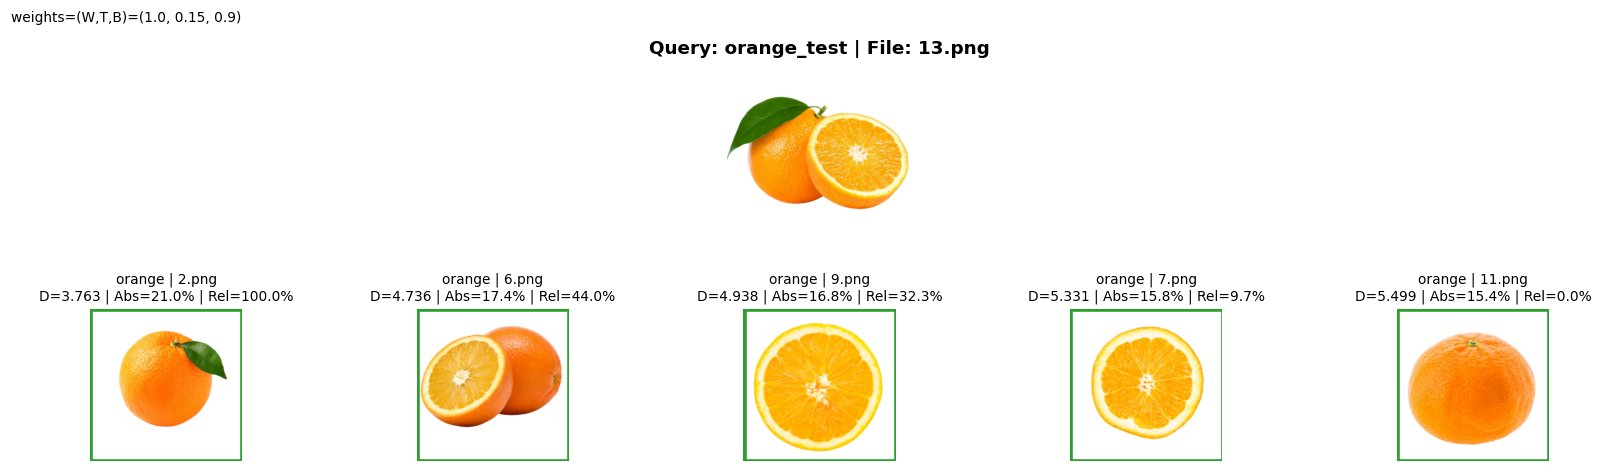


Query file: 13.png



,Rank,Label,File,Distance,Abs%,Rel%
0,1,orange,2.png,3.763391,20.993450,100.000000
1,2,orange,6.png,4.736168,17.433241,43.961726
2,3,orange,9.png,4.937740,16.841424,32.349867
3,4,orange,7.png,5.330832,15.795713,9.705251
4,5,orange,11.png,5.499307,15.386257,0.000000


------------------------------------------------------------


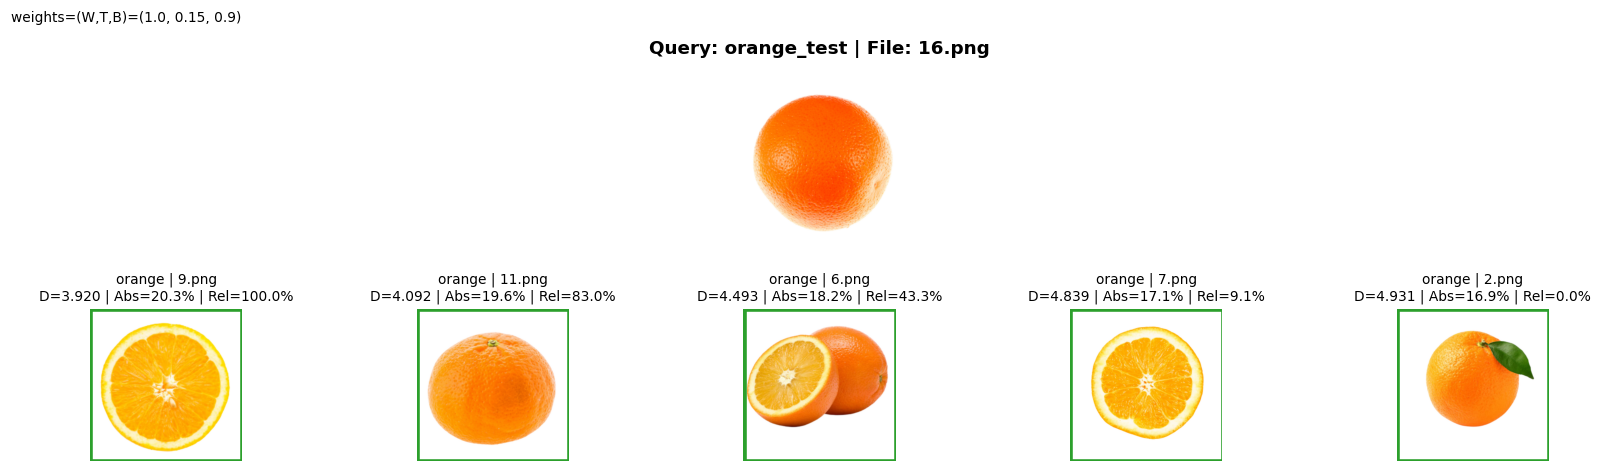


Query file: 16.png



,Rank,Label,File,Distance,Abs%,Rel%
0,1,orange,9.png,3.919717,20.326371,100.000000
1,2,orange,11.png,4.091528,19.640471,83.004135
2,3,orange,6.png,4.493186,18.204372,43.271215
3,4,orange,7.png,4.838756,17.126937,9.086662
4,5,orange,2.png,4.930612,16.861665,0.000000


------------------------------------------------------------


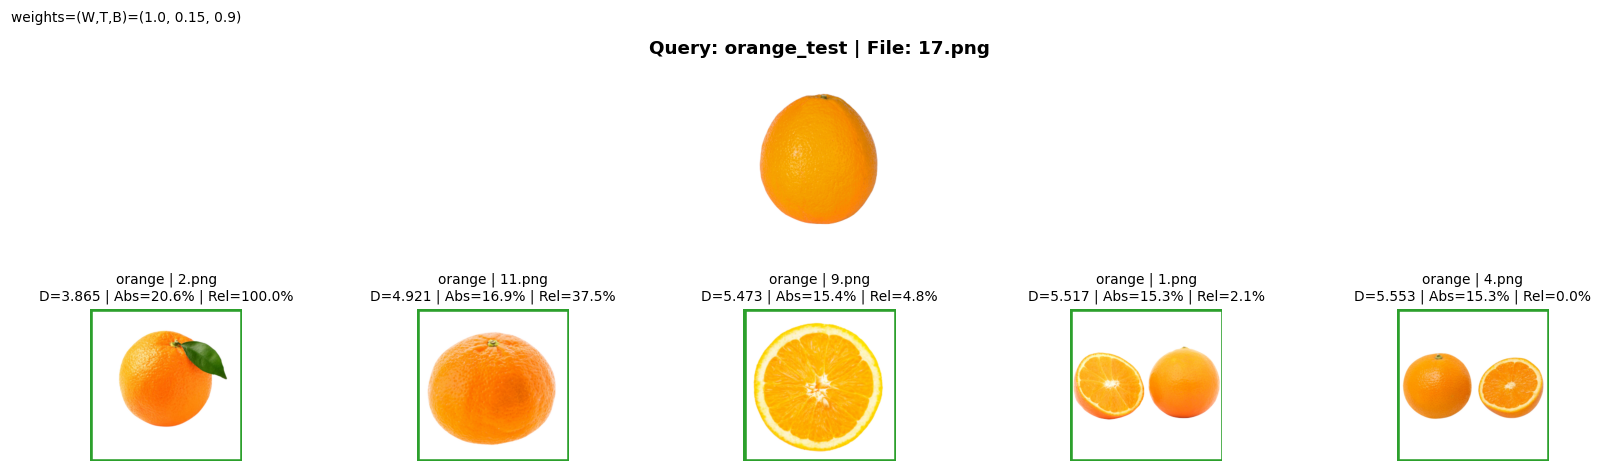


Query file: 17.png



,Rank,Label,File,Distance,Abs%,Rel%
0,1,orange,2.png,3.865161,20.554303,100.000000
1,2,orange,11.png,4.920553,16.890314,37.478947
2,3,orange,9.png,5.472585,15.449778,4.776758
3,4,orange,1.png,5.517453,15.343417,2.118785
4,5,orange,4.png,5.553219,15.259676,0.000000


------------------------------------------------------------


In [ ]:
# Inisialisasi variabel
weights_try = (1.0, 0.15, 0.9)
metric_try  = 'euclidean'
EXTS = ("*.jpg", "*.jpeg", "*.png")

# Menampilkan hasil retrieval untuk setiap file di folder query
for qcls in sorted([d for d in os.listdir(query_root) if os.path.isdir(os.path.join(query_root, d))]):
    files = []
    for ext in EXTS:
        files += glob.glob(os.path.join(query_root, qcls, ext))

    for qp in sorted(files):
        show_topk(qp, feats_pack, df_index, scalers,
                  weights=weights_try, metric=metric_try, topk=5)


#LANGKAH 4

In [ ]:
# EVALUASI - Precision@5 per kelas dan rata-rata makro
import os, glob
import numpy as np
import pandas as pd

EXTS = ("*.jpg", "*.jpeg", "*.png")

def list_query_images(qroot):
    hasil = []
    for qcls in sorted([d for d in os.listdir(qroot) if os.path.isdir(os.path.join(qroot, d))]):
        files = []
        for ext in EXTS:
            files += glob.glob(os.path.join(qroot, qcls, ext))
        for p in sorted(files):
            hasil.append((qcls, p))
    return hasil

def precision_at_5(query_root, feats_pack, df_index, scalers,
                   weights=(1.0, 0.0, 0.0), metric='euclidean'):
    baris = []
    for qcls, qpath in list_query_images(query_root):
        _, res = retrieve(qpath, feats_pack, df_index, scalers,
                          topk=5, weights=weights, metric=metric)
        true_lbl = base_label(qcls)
        prec5 = np.mean([base_label(lbl) == true_lbl for _, _, lbl in res])
        baris.append({"query_cls": qcls, "prec5": float(prec5)})

    df = pd.DataFrame(baris)
    per_cls = df.groupby("query_cls", as_index=False)["prec5"].mean()
    macro = float(per_cls["prec5"].mean())
    return per_cls, macro


In [ ]:
# Konfigurasi pengujian Precision@5
cfgs = {
    "A) Warna (HSV + statistik)": (1.0, 0.0, 0.0),
    "B) Tekstur (GLCM)"         : (0.0, 1.0, 0.0),
    "C) Gabungan"               : (1.0, 0.15, 0.90)
}

all_tables = {}
summary = []

for name, w in cfgs.items():
    per_cls, macro = precision_at_5(query_root, feats_pack, df_index, scalers,
                                    weights=w, metric='euclidean')
    all_tables[name] = per_cls.copy()

    print(f"\n{name} - weights={w}, metric=euclidean")
    display(per_cls.rename(columns={'query_cls': 'Kelas', 'prec5': 'Precision@5'}))
    print(f"Rata-rata Precision@5 (makro): {macro:.3f}")

    summary.append((name, w, macro))

# Ringkasan hasil makro
summary_df = pd.DataFrame(summary, columns=['Konfigurasi', 'Bobot (W, T, B)', 'Macro P@5'])
print("\nRINGKASAN HASIL MAKRO")
display(summary_df.sort_values('Macro P@5', ascending=False).reset_index(drop=True))



A) Warna (HSV + statistik) - weights=(1.0, 0.0, 0.0), metric=euclidean


,Kelas,Precision@5
0,apple_test,1.000000
1,banana_test,0.866667
2,kiwi_test,0.933333
3,orange_test,1.000000


Rata-rata Precision@5 (makro): 0.950

B) Tekstur (GLCM) - weights=(0.0, 1.0, 0.0), metric=euclidean


,Kelas,Precision@5
0,apple_test,1.000000
1,banana_test,1.000000
2,kiwi_test,0.800000
3,orange_test,0.333333


Rata-rata Precision@5 (makro): 0.783

C) Gabungan - weights=(1.0, 0.15, 0.9), metric=euclidean


,Kelas,Precision@5
0,apple_test,1.0
1,banana_test,1.0
2,kiwi_test,1.0
3,orange_test,1.0


Rata-rata Precision@5 (makro): 1.000

RINGKASAN HASIL MAKRO


,Konfigurasi,"Bobot (W, T, B)",Macro P@5
0,C) Gabungan,"(1.0, 0.15, 0.9)",1.000000
1,A) Warna (HSV + statistik),"(1.0, 0.0, 0.0)",0.950000
2,B) Tekstur (GLCM),"(0.0, 1.0, 0.0)",0.783333


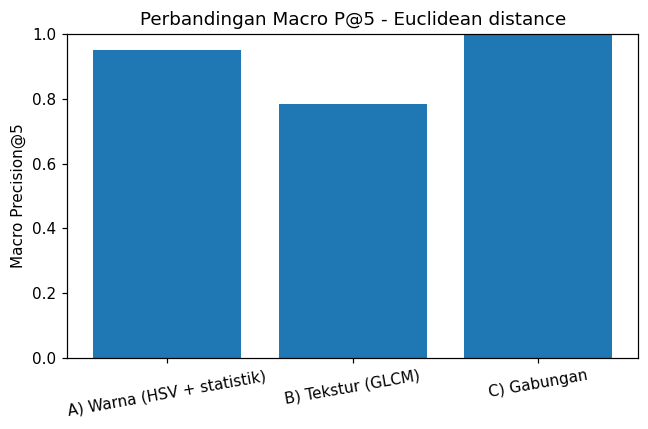

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar([s[0] for s in summary], [s[2] for s in summary])
plt.ylabel('Macro Precision@5')
plt.ylim(0,1.0)
plt.title('Perbandingan Macro P@5 - Euclidean distance')
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()
